<a href="https://colab.research.google.com/github/sakethrammamidi/Portfolio-Analysis/blob/main/Portfolio__Analysis_By_Sakethram_Mamidi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance

Import Necessary Libraries

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

Data Collection - Top 50 Stocks

In [ ]:
tickers = [
    'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'TSLA', 'NVDA', 'BRK-B', 'JPM', 'JNJ',
    'V', 'PG', 'UNH', 'HD', 'DIS', 'MA', 'PYPL', 'BAC', 'VZ', 'ADBE',
    'CMCSA', 'NFLX', 'KO', 'PEP', 'XOM', 'INTC', 'CSCO', 'PFE', 'T', 'MRK',
    'ABT', 'CRM', 'WMT', 'ABBV', 'ORCL', 'ACN', 'MCD', 'NKE', 'LLY', 'QCOM',
    'COST', 'TXN', 'MDT', 'NEE', 'HON', 'PM', 'DHR', 'BMY', 'UPS', 'LIN'
]
data = yf.download(tickers, start='2020-01-01', end='2023-01-01')['Adj Close']

[*********************100%***********************]  50 of 50 completed


Data Preprocessing

In [ ]:
returns = data.pct_change().dropna()

Risk and Return Calculation

In [ ]:
annual_returns = returns.mean() * 252
annual_volatility = returns.std() * (252 ** 0.5)
cov_matrix = returns.cov() * 252
# Function to calculate returns and volatility
def calculate_returns_volatility(data):
    returns = data.pct_change().dropna()
    mean_returns = returns.mean() * 252
    cov_matrix = returns.cov() * 252
    return mean_returns, cov_matrix

# Function to calculate ROI over a period
def calculate_roi_percentage(annual_return, years):
    return ((1 + annual_return) ** years - 1) * 100

# Function to perform sensitivity analysis
def sensitivity_analysis(mean_returns, cov_matrix, years):
    return_range = np.linspace(0, 0.2, 11)  # Vary return from 0% to 20%
    volatility_range = np.linspace(0.1, 0.3, 11)  # Vary volatility from 10% to 30%

    roi_results = np.zeros((len(return_range), len(volatility_range)))

    for i, ret in enumerate(return_range):
        for j, vol in enumerate(volatility_range):
            adj_mean_returns = mean_returns * ret
            adj_cov_matrix = cov_matrix * vol

            result = max_sharpe_ratio(adj_mean_returns, adj_cov_matrix)
            optimal_weights = result.x
            annualized_return = np.dot(optimal_weights, adj_mean_returns)
            roi_results[i, j] = calculate_roi_percentage(annualized_return, years)

    return return_range, volatility_range, roi_results


Optimization

In [ ]:
def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0.0):
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return -sharpe_ratio

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate=0.0):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))
    result = minimize(negative_sharpe_ratio, num_assets * [1. / num_assets,], args=args,
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result

 Sensitivity Analysis

Sensitivity Analysis for ROI over 5 years:
Return Range: [0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2 ]
Volatility Range: [0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26 0.28 0.3 ]
ROI (%)
[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 4.49051997  4.4911313   4.48966286  4.48726355  4.49289529  4.49029574
   4.48970897  4.48879738  4.48711041  4.48419714  4.49026461]
 [ 9.1492452   9.14724584  9.14260768  9.14318169  9.14257378  9.14232339
   9.14333983  9.14003772  9.14107048  9.14191352  9.14224219]
 [13.95156751 13.94947093 13.96203422 13.9726701  13.96382222 13.96625103
  13.96832758 13.96801135 13.96661474 13.96378239 13.96051331]
 [18.92835347 18.92627643 18.92550077 18.91827285 18.93539231 18.92867397
  18.92965423 18.94765111 18.949664   18.94725134 18.95798068]
 [24.07744779 24.07589566 24.07435403 24.07929635 24.07610772 24.0685975
  24.07743048 24.0656387  24.07312464 24.08918381 24.

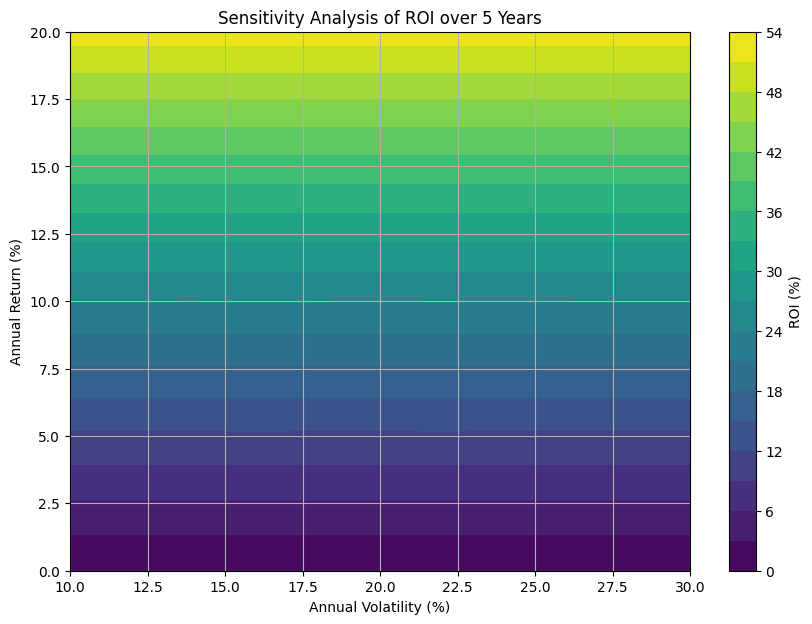

In [ ]:
years = 5  # Example investment period

mean_returns, cov_matrix = calculate_returns_volatility(data)
return_range, volatility_range, roi_results = sensitivity_analysis(mean_returns, cov_matrix, years)

# Print and visualize sensitivity analysis results
print(f"Sensitivity Analysis for ROI over {years} years:")
print(f"Return Range: {return_range}")
print(f"Volatility Range: {volatility_range}")
print("ROI (%)")
print(roi_results)

# Plotting sensitivity analysis results
plt.figure(figsize=(10, 7))
plt.contourf(volatility_range * 100, return_range * 100, roi_results, levels=20, cmap='viridis')
plt.colorbar(label='ROI (%)')
plt.title(f'Sensitivity Analysis of ROI over {years} Years')
plt.xlabel('Annual Volatility (%)')
plt.ylabel('Annual Return (%)')
plt.grid(True)
plt.show()

Backtesting

In [ ]:
# Assuming 'optimal_weights' is calculated using the 'max_sharpe_ratio' function
result = max_sharpe_ratio(mean_returns, cov_matrix)
optimal_weights = result.x  # Extract optimal weights from the result object

portfolio_returns = np.dot(returns, optimal_weights)
cumulative_returns = (1 + portfolio_returns).cumprod()

Visualization

In [ ]:
def plot_efficient_frontier(mean_returns, cov_matrix, num_portfolios=10000, risk_free_rate=0.0):
    results = np.zeros((3, num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_return, portfolio_risk = portfolio_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_risk
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_risk

    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0, max_sharpe_idx], results[1, max_sharpe_idx]

    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:], results[1,:], c=results[2,:], cmap='YlGnBu', marker='o')
    plt.scatter(sdp, rp, marker='*', color='r', s=500, label='Maximum Sharpe ratio')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('Volatility (Risk)')
    plt.ylabel('Returns')
    plt.colorbar(label='Sharpe ratio')
    plt.legend(labelspacing=0.8)
    plt.show()


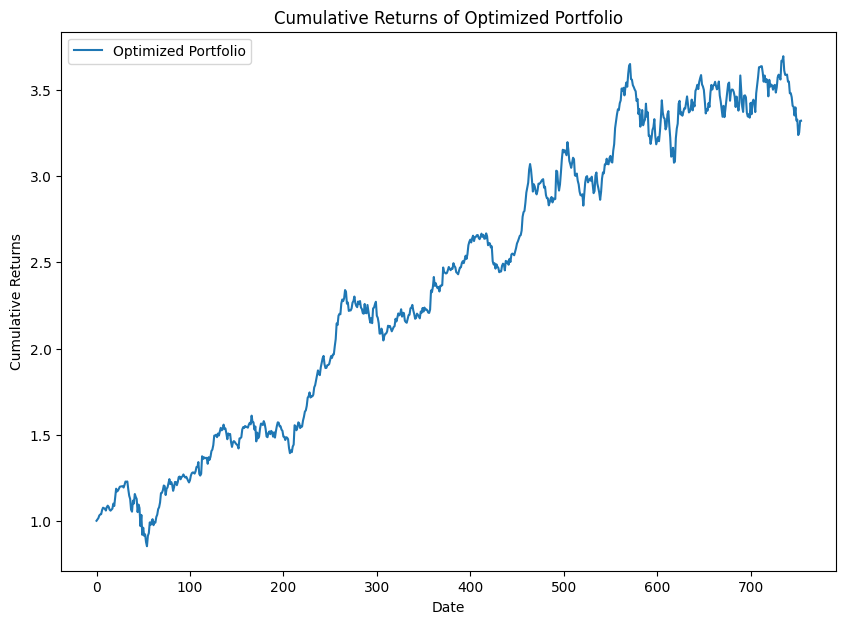

In [ ]:
# Plot Cumulative Returns of the Optimized Portfolio
plt.figure(figsize=(10, 7))
plt.plot(cumulative_returns, label='Optimized Portfolio')
plt.title('Cumulative Returns of Optimized Portfolio')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

<ipython-input-11-77274c5af642>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (annual_volatility[i], annual_returns[i]), fontsize=8)


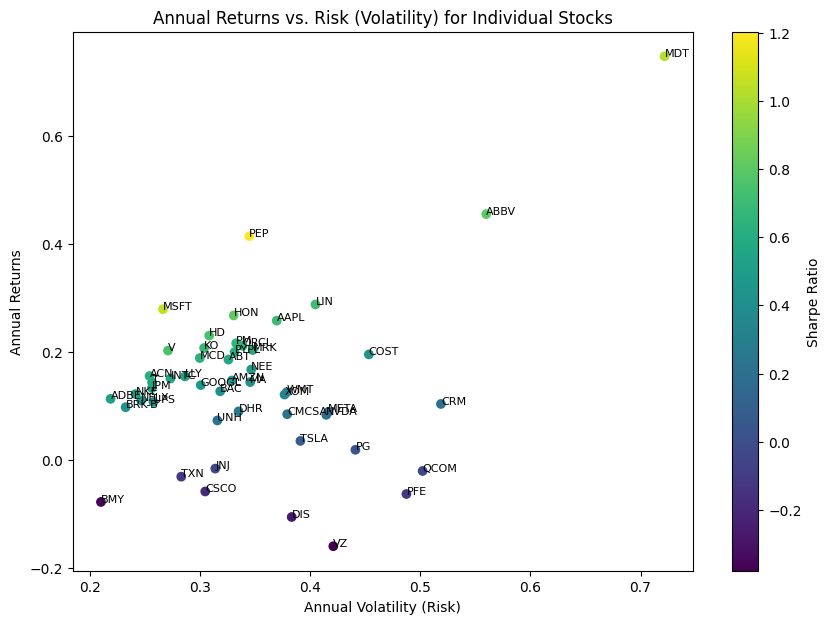

In [ ]:
# Individual Stock Returns vs. Risk
plt.figure(figsize=(10, 7))
plt.scatter(annual_volatility, annual_returns, c=annual_returns/annual_volatility, cmap='viridis', marker='o')
for i, txt in enumerate(tickers):
    plt.annotate(txt, (annual_volatility[i], annual_returns[i]), fontsize=8)
plt.title('Annual Returns vs. Risk (Volatility) for Individual Stocks')
plt.xlabel('Annual Volatility (Risk)')
plt.ylabel('Annual Returns')
plt.colorbar(label='Sharpe Ratio')
plt.show()

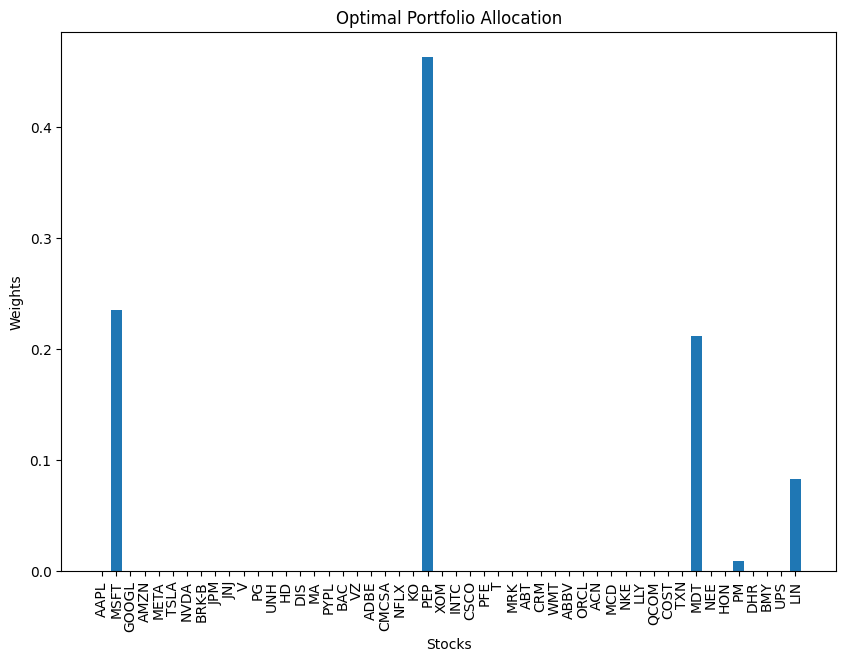

In [ ]:
# Portfolio Allocation
plt.figure(figsize=(10, 7))
plt.bar(tickers, optimal_weights)
plt.title('Optimal Portfolio Allocation')
plt.xlabel('Stocks')
plt.ylabel('Weights')
plt.xticks(rotation=90)
plt.show()

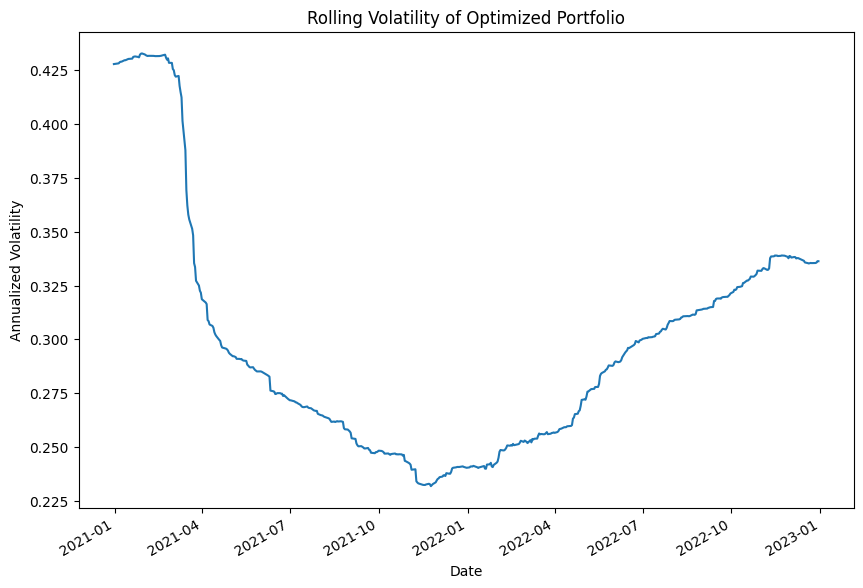

In [ ]:
# Rolling Volatility
rolling_volatility = returns.rolling(window=252).std() * np.sqrt(252)
plt.figure(figsize=(10, 7))
rolling_volatility.mean(axis=1).plot()
plt.title('Rolling Volatility of Optimized Portfolio')
plt.xlabel('Date')
plt.ylabel('Annualized Volatility')
plt.show()

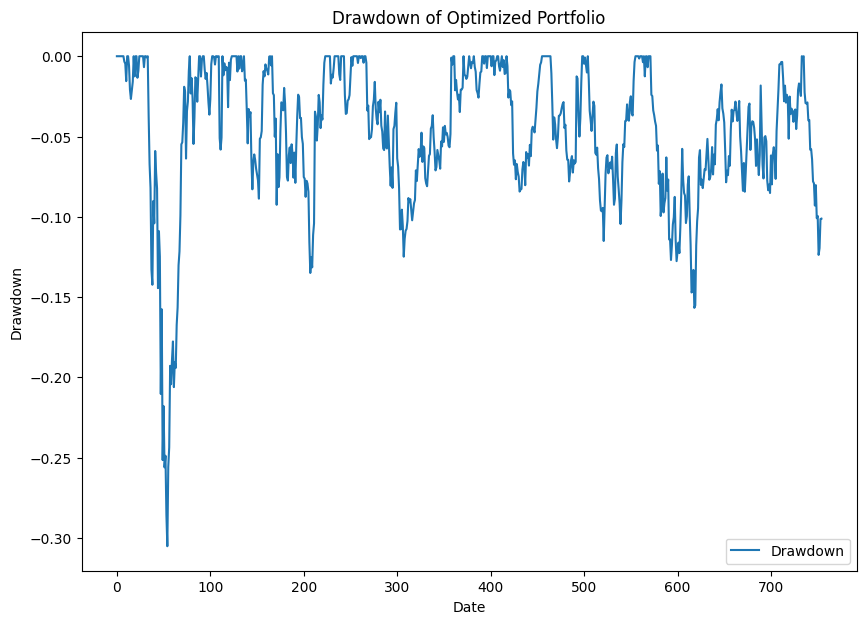

In [ ]:
# Drawdown Chart
cumulative_returns = (1 + portfolio_returns).cumprod()
running_max = np.maximum.accumulate(cumulative_returns)
drawdown = (cumulative_returns - running_max) / running_max
plt.figure(figsize=(10, 7))
plt.plot(drawdown, label='Drawdown')
plt.title('Drawdown of Optimized Portfolio')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.legend()
plt.show()

In [ ]:
# Performance evaluation
optimal_return = np.dot(optimal_weights, annual_returns)
optimal_risk = np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights)))
optimal_sharpe = (optimal_return - 0.0) / optimal_risk
print(f"Optimal Weights: {optimal_weights}")
print(f"Expected Annual Return: {optimal_return:.2f}")
print(f"Annual Volatility: {optimal_risk:.2f}")
print(f"Sharpe Ratio: {optimal_sharpe:.2f}")

Optimal Weights: [0.00000000e+00 2.34540330e-01 6.71232124e-16 4.93688870e-16
 7.44539895e-16 6.17635985e-16 6.88768915e-16 0.00000000e+00
 4.48353246e-16 6.52557741e-16 0.00000000e+00 1.75304349e-17
 0.00000000e+00 0.00000000e+00 2.00924176e-17 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.98681559e-15 0.00000000e+00
 8.73326201e-17 0.00000000e+00 0.00000000e+00 4.62511597e-01
 2.05354149e-16 7.05106595e-17 9.76254722e-16 3.81190086e-16
 0.00000000e+00 1.93060367e-16 0.00000000e+00 7.39752359e-16
 4.37836924e-16 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 2.11640274e-01 0.00000000e+00
 4.07850935e-17 8.52945345e-03 7.34931224e-16 3.67011918e-16
 0.00000000e+00 8.27783457e-02]
Expected Annual Return: 0.44
Annual Volatility: 0.28
Sharpe Ratio: 1.56


Estimated Returns Over Various Time Periods

In [ ]:
# Function to calculate more realistic ROI estimates considering volatility and risk
def calculate_realistic_roi(mean_returns, cov_matrix, years):
    num_simulations = 1000
    num_assets = len(mean_returns)

    # Simulate returns using multivariate normal distribution
    simulated_returns = np.random.multivariate_normal(mean_returns, cov_matrix, num_simulations)

    # Calculate expected annualized returns from simulated returns
    expected_annualized_returns = np.mean(simulated_returns, axis=1)

    # Calculate realistic ROI based on expected annualized return
    realistic_annualized_return = np.mean(expected_annualized_returns)
    realistic_roi = calculate_roi_percentage(realistic_annualized_return, years) # You will need to define this function

    return realistic_roi

# Define the investment periods and their durations
periods = {
    "6 Months": 0.5,
    "1 Year": 1,
    "5 Years": 5,
    "10 Years": 10
}

# Calculate more realistic ROI for each period
realistic_roi_percentages = {period: calculate_realistic_roi(annual_returns.values, cov_matrix.values, years) for period, years in periods.items()}

# Display more realistic ROI percentages
for period, roi in realistic_roi_percentages.items():
    print(f"Realistic ROI over {period}: {roi:.2f}%")

# Example 'calculate_roi_percentage' function. You will need to adjust this to fit your needs.
def calculate_roi_percentage(annualized_return, years):
    return (pow(1 + annualized_return, years) - 1) * 100




Realistic ROI over 6 Months: 6.10%
Realistic ROI over 1 Year: 12.20%
Realistic ROI over 5 Years: 98.41%
Realistic ROI over 10 Years: 292.86%
